In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import os
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import re
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate

/home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-07 15:56:32.377322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 15:56:32.681383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738961792.808277  562750 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738961792.8

In [2]:
# Download latest version
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
print("Path to dataset files:", path)

# or if on kaggle, use it's data, uncomment the following line
# path = "/kaggle/input/yelp-dataset"

def load_data(path, filename, truncate=None):
    data_file = open(os.path.join(path, filename))
    data = []
    if truncate is not None:
        for i, line in enumerate(data_file):
            data.append(json.loads(line))
            if i == truncate:
                break
        # for line in data_file[0:truncate]:
        #     data.append(json.loads(line))
    else:
        for line in data_file:
            data.append(json.loads(line))
    ret_df = pd.DataFrame(data)
    data_file.close()
    return ret_df


businesses_df = load_data(path, "yelp_academic_dataset_business.json")
reviews_df = load_data(path, "yelp_academic_dataset_review.json", truncate=10000)
tips_df = load_data(path, "yelp_academic_dataset_tip.json")

Path to dataset files: /home/abhay/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4


In [3]:
display(businesses_df)

display(reviews_df)

display(tips_df)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
9996,UIkEO-10J6Y99IhRqUflvg,lYAmgL_l7A3MPFYe1DYKrw,EpREWeEpmR8f1qLHzzF0AA,5.0,0,1,0,Just about to get tucked into a meatloaf that ...,2018-01-09 20:26:13
9997,S-NQM3Axcg8JS3MXHUIvyw,rE2WwfgJbYfvDwBlgq__dQ,dvidzWEPgTQPeBc8CUV2OQ,5.0,0,0,0,Outstanding customer service! And my car is dr...,2015-04-01 21:50:28
9998,ME79YrEhm2xe4IQy_0zkGw,OnIklvzKDpk1BduC84TrTA,2XYPFRm7teCUr3eGsB2-qw,5.0,0,0,0,I and my husband went here for Dinner one day ...,2015-06-08 19:32:26
9999,05oKtleZ-JFGD6qt47VQcg,p0MhNWkwOPBfRo8qUb7faw,rnaE88k8yV5pFAGJeiIK4Q,2.0,0,0,0,I saw Big Data when they came to town at the K...,2015-08-06 23:16:58


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
...,...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57,0
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36,0
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56,0
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44,0


In [5]:
# the businesses in the db that are open vs those not open
businesses_open = businesses_df[businesses_df['is_open'] == 1]
print("Businesses open: ", len(businesses_open))

businesses_closed = businesses_df[businesses_df['is_open'] == 0]
print("Businesses closed: ", len(businesses_closed))

Businesses open:  119698
Businesses closed:  30648


In [6]:
all_unique_cats = {}

for index, row in businesses_df.iterrows():
    if not row['categories']:
        continue
        
    diff_cats = row['categories'].split(", ")
    for cat in diff_cats:
        if cat in all_unique_cats:
            all_unique_cats[cat] += 1
        else:
            all_unique_cats[cat] = 1

sorted_cats = sorted(all_unique_cats.items(), key=lambda x: x[1], reverse=True)
print("Top 10 categories: ", sorted_cats[:10])

Top 10 categories:  [('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty & Spas', 14292), ('Nightlife', 12281), ('Health & Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773)]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Restaurants'),
  Text(1, 0, 'Food'),
  Text(2, 0, 'Shopping'),
  Text(3, 0, 'Home Services'),
  Text(4, 0, 'Beauty & Spas'),
  Text(5, 0, 'Nightlife'),
  Text(6, 0, 'Health & Medical'),
  Text(7, 0, 'Local Services'),
  Text(8, 0, 'Bars'),
  Text(9, 0, 'Automotive'),
  Text(10, 0, 'Event Planning & Services'),
  Text(11, 0, 'Sandwiches'),
  Text(12, 0, 'American (Traditional)'),
  Text(13, 0, 'Active Life'),
  Text(14, 0, 'Pizza'),
  Text(15, 0, 'Coffee & Tea'),
  Text(16, 0, 'Fast Food'),
  Text(17, 0, 'Breakfast & Brunch'),
  Text(18, 0, 'American (New)'),
  Text(19, 0, 'Hotels & Travel'),
  Text(20, 0, 'Home & Garden'),
  Text(21, 0, 'Fashion'),
  Text(22, 0, 'Burgers'),
  Text(23, 0

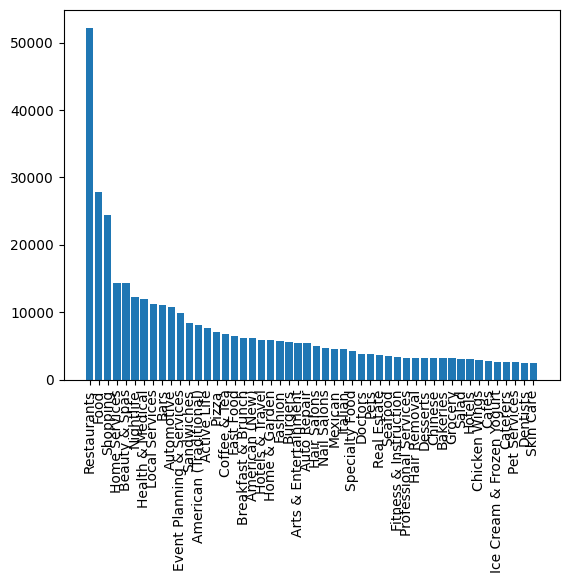

In [7]:
num_cats = 50
plt.bar([x[0] for x in sorted_cats[:num_cats]], [x[1] for x in sorted_cats[:num_cats]])
plt.xticks(rotation=90)

In [8]:
businesses_df["categories"] = businesses_df["categories"].apply(lambda x: x.split(", ") if x else "")

businesses_df["categories"] = businesses_df["categories"].apply(lambda x: [cat for cat in x if cat != "Restaurants"])

reviews_business_df = pd.merge(reviews_df, businesses_df, on="business_id")

reviews_business_df

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","[Breakfast & Brunch, Food, Juice Bars & Smooth...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","[Active Life, Cycling Classes, Trainers, Gyms,...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...",[Breakfast & Brunch],None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","[Halal, Pakistani, Indian]","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","[Sandwiches, Beer, Wine & Spirits, Bars, Food,...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,UIkEO-10J6Y99IhRqUflvg,lYAmgL_l7A3MPFYe1DYKrw,EpREWeEpmR8f1qLHzzF0AA,5.0,0,1,0,Just about to get tucked into a meatloaf that ...,2018-01-09 20:26:13,Schlafly Bottleworks,...,MO,63143,38.613090,-90.314761,4.0,615,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","[Local Flavor, Food, Brewpubs, Breweries, Pizz...","{'Wednesday': '11:0-21:0', 'Thursday': '11:0-2..."
9997,S-NQM3Axcg8JS3MXHUIvyw,rE2WwfgJbYfvDwBlgq__dQ,dvidzWEPgTQPeBc8CUV2OQ,5.0,0,0,0,Outstanding customer service! And my car is dr...,2015-04-01 21:50:28,Tires Plus,...,PA,19031,40.113360,-75.214510,3.0,31,1,{'BusinessAcceptsCreditCards': 'True'},"[Tires, Automotive, Oil Change Stations, Auto ...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '..."
9998,ME79YrEhm2xe4IQy_0zkGw,OnIklvzKDpk1BduC84TrTA,2XYPFRm7teCUr3eGsB2-qw,5.0,0,0,0,I and my husband went here for Dinner one day ...,2015-06-08 19:32:26,Thai Orchid,...,PA,19422,40.150408,-75.304625,4.0,195,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",[Thai],"{'Monday': '11:30-21:30', 'Tuesday': '11:30-21..."
9999,05oKtleZ-JFGD6qt47VQcg,p0MhNWkwOPBfRo8qUb7faw,rnaE88k8yV5pFAGJeiIK4Q,2.0,0,0,0,I saw Big Data when they came to town at the K...,2015-08-06 23:16:58,Knitting Factory Reno,...,NV,89501,39.527124,-119.813698,3.5,75,0,"{'OutdoorSeating': 'False', 'GoodForKids': 'Fa...","[Food, Beer, Wine & Spirits, Music Venues, Art...","{'Monday': '17:0-23:30', 'Tuesday': '17:0-23:3..."


In [9]:
all_cats = [x[0] for x in sorted_cats[:num_cats]]

mlb = sklearn.preprocessing.MultiLabelBinarizer()

y = mlb.fit_transform(reviews_business_df["categories"])

In [10]:
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews_business_df["text"])

X = tokenizer.texts_to_sequences(reviews_business_df["text"])
X = pad_sequences(X, maxlen=max_len, padding="post", truncating="post")

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation="relu"),
    Dense(y.shape[1], activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Takes approx. 5 mins
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=32)


Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.0219 - loss: 0.1908 - val_accuracy: 0.0320 - val_loss: 0.0253
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.0341 - loss: 0.0257 - val_accuracy: 0.0320 - val_loss: 0.0252
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.0307 - loss: 0.0254 - val_accuracy: 0.0320 - val_loss: 0.0252
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.0334 - loss: 0.0257 - val_accuracy: 0.0320 - val_loss: 0.0252
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.0311 - loss: 0.0255 - val_accuracy: 0.0320 - val_loss: 0.0252
Epoch 6/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.0344 - loss: 0.0254 - val_accuracy: 0.0320 - val_loss: 0.0252
Epoch 7/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.0314 - loss: 0.0254 - val_accuracy: 0.0235 - val_loss: 0.0252
Epoch 8/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.0319 - loss: 0

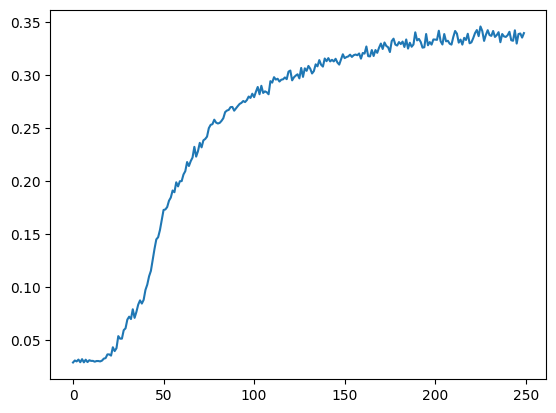

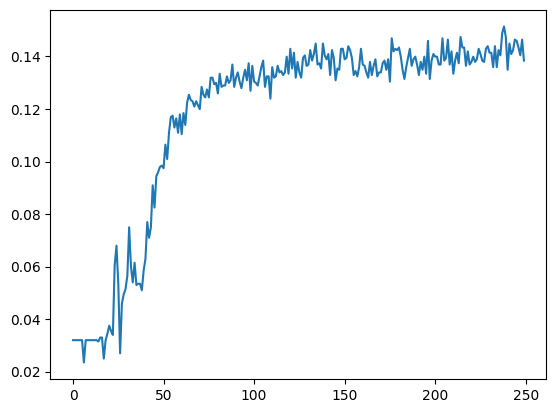

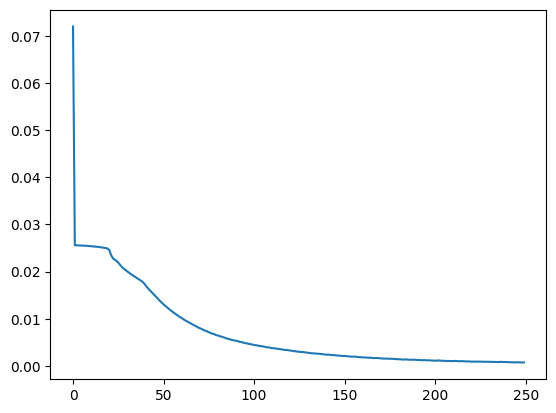

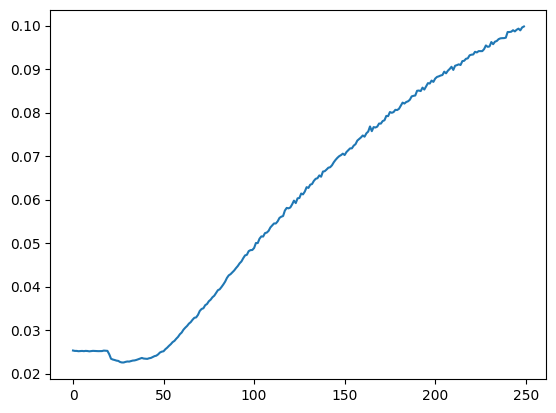

In [13]:
plt.plot(history.history["accuracy"])
plt.show()
plt.plot(history.history["val_accuracy"])
plt.show()

plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_loss"])
plt.show()

In [47]:
y_val[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1]:
# For predicting from the entire data corpus:

# rand_num = np.random.randint(0, len(reviews_business_df))
# the_text = reviews_business_df["text"][rand_num]
# display(the_text)
# sequence = tokenizer.texts_to_sequences([the_text])
# padded_sequence = pad_sequences(sequence, maxlen=max_len, padding="post", truncating="post")
# pred = model.predict(padded_sequence)

rand_num = np.random.randint(0, X_val.shape[0])
pred = model.predict(X_val[rand_num].reshape(1, -1))

pred_labels = mlb.inverse_transform((pred > 0.5).astype(int))

print("Predicted:", str(pred_labels))

print("Actual: ", mlb.inverse_transform(y_val[rand_num].reshape(1, -1)))

# print("Actual: ", reviews_business_df["categories"][rand_num])

NameError: name 'np' is not defined

# Save a model

In [15]:
if not os.path.exists('models'):
    os.mkdir('models', )
num = 0
path = os.path.join('models', f'yelp_review_model{num}.keras')
while path in os.listdir('models'):
    num += 1
    path = os.path.join('models', f'yelp_review_model{num}.keras')
model.save(path)

# Extract from pre-made, saved model model

In [6]:
model = tf.keras.models.load_model(os.path.join('models', 'yelp_review_model1.keras'))

I0000 00:00:1738962043.536939  563865 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
W0000 00:00:1738962043.883436  564080 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/abhay/Documents/Repo/abhayma1000/DS3010FinalProject/venv/lib/python3.12

UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 